In [3]:
# Import libaries and illustris library
import numpy as np
import illustris_python as il
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib import gridspec
%matplotlib inline
import random
import subroutines.tree_functions as tf
hubble = 0.704
import sys
sys.path.append("/Users/alex/Documents/Research/Astro/illustrisAPI")
import iApi as iapi
iapi.headers['api-key']='4bf1a1e26a9a0777777dd7fa074e2e1f'

In [53]:
plt.style.use('default')
mpl.rcParams['lines.linewidth']=2
mpl.rcParams['font.size']=15
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['ytick.major.size'] = 7

yor__cmap = mpl.cm.get_cmap('YlOrRd');
vir__cmap = mpl.cm.get_cmap('viridis');
greys__cmap = mpl.cm.get_cmap('Greys');

%reload_ext autoreload
%autoreload 2

In [4]:
def maskEllips(whichSnap):
    return (galData[whichSnap][:,14]<0.5);
def maskMass(whichSnap, mass_low, mass_high=50000):
    return ( (mass_high>galData[whichSnap][:,2]) & (galData[whichSnap][:,2]>mass_low) );
def maskMass_data(data, mass_low, mass_high=50000):
    return ( (mass_high>data) & (data>mass_low) );
def maskWeb(whichSnap, webValue):
    return (webData[whichSnap][:,17]==webValue);
def maskWeb_ellip(whichSnap, webValue):
    return (webData_ellip[whichSnap][:,17]==webValue);

In [5]:
#load data
snaps=[135,116,103,85]
galData = []
webData = []
for i in snaps:
    # 0:HaloNumber, 1:SubhaloNumber, 2:StellarMass, 3:GasMass, 4:DarkMatterMass, 5-7:SubhaloPosition x,y,z
    # 8-10:CoM Velocity x, CoM Velocity y, CoM Velocity z, 11-13:AngularMomentum x, AngularMomentum y, AngularMomentum z, 
    # 14:Kappa, 15:Flatness, 16:Ellip, 17:Lambda, 18:BHMass 19:BMMassDot 20:StarFormationRate (MDot) 21:N(sub_z=0) 22:N(sub_z_next) 23:N(sub_z_previous)
    galData.append(np.genfromtxt('../../Data/GalaxyData/GalaxyData_Snap.'+str(i)+'.txt'))

    # 0:HaloNumber, 1:SubhaloNumber, 2-4:SubhaloPosition x,y,z, 5: Index of nearest critical point, 6: absolute distance to crit., 7-9: nearest critical point coordinates, 
    # 10: Index of nearest filament, 11:absolute distance to filament, 12-14: nearest filament coordinates, 15: cos(theta) 16:sin(theta) 17:cluster(1) fil(0) nothing(-1)
    # 17: cluster=1, filament=0, none=-1
    webData.append(np.genfromtxt('../../Data/WebData/galaxy_web_data.'+str(i)+'.txt'))

galData_ellip = []; galData_disk = [];
webData_ellip = []; webData_disk = [];
for i in range (0,4):
    galData_ellip.append(galData[i][maskEllips(i)])
    webData_ellip.append(webData[i][maskEllips(i)])
    galData_disk.append(galData[i][~maskEllips(i)])
    webData_disk.append(webData[i][~maskEllips(i)])
#load all galaxy data
allgalData = []
for i in range (135,84,-1):
    # 0:HaloNumber, 1:SubhaloNumber, 2:StellarMass, 3:GasMass, 4:DarkMatterMass, 5-7:SubhaloPosition x,y,z
    # 8-10:CoM Velocity x, CoM Velocity y, CoM Velocity z, 11-13:AngularMomentum x, AngularMomentum y, AngularMomentum z, 
    # 14:Kappa, 15:Flatness, 16:Ellip, 17:Lambda, 18:BHMass 19:BMMassDot 20:StarFormationRate (MDot) 21:N(sub_z=0) 22:N(sub_z_next) 23:N(sub_z_previous)
    allgalData.append(np.genfromtxt('../../Data/GalaxyData/GalaxyData_Snap.'+str(i)+'.txt'))

allgalData_ellip = []; allgalData_disk = [];
for i in range(0,51):
    allgalData_ellip.append(allgalData[i][allgalData[i][:,14]<0.5]);
    allgalData_disk.append(allgalData[i][allgalData[i][:,14]>0.5]);

In [399]:
noMaj_nsnap = np.genfromtxt('../../Data/noMajors_nsub.txt').astype(int)
subhalo_numbers = np.genfromtxt('subhalo_numbers.txt').astype(int)

In [359]:
def find_gal_in_rad(pos_data, mass_data, vel_data, index_of_gal, rad = 1000, mass=0.1):
    gal_position = pos_data[index_of_gal,:]
    pos_mask = (((gal_position[0]+rad)>pos_data[:,0]) & (pos_data[:,0]>(gal_position[0]-rad)) & 
                ((gal_position[1]+rad)>pos_data[:,1]) & (pos_data[:,1]>(gal_position[1]-rad)) &
                ((gal_position[2]+rad)>pos_data[:,2]) & (pos_data[:,2]>(gal_position[2]-rad)) &
                ((gal_position[2]) != pos_data[:,2])
               )
    mass_mask = mass_data[:]>mass
    return pos_data[pos_mask & mass_mask]-gal_position, mass_data[pos_mask & mass_mask], vel_data[pos_mask & mass_mask], gal_position, mass_data[index_of_gal]

In [458]:
positions = []
masses = []
velocities= []
for snapNum in np.arange(110,84,-1):
    positions.append(iapi.getSubhaloField('SubhaloPos',snapshot=snapNum, rewriteFile=0, fileName=pathToDir+'SubhaloPos.'+str(snapNum)))
    masses.append(iapi.getSubhaloField('SubhaloMassType',snapshot=snapNum, rewriteFile=0, fileName=pathToDir+'SubhaloMassType.'+str(snapNum))[:,1])
    velocities.append(iapi.getSubhaloField('SubhaloVel',snapshot=snapNum, rewriteFile=0, fileName=pathToDir+'SubhaloVel.'+str(snapNum)))

In [332]:
def mass_color_map(mass_data, steps, max_mass=-1, min_mass=-1):
    output = np.zeros((mass_data.shape[0]))
    if max_mass == -1:
        max_mass=max(mass_data[:])
    if min_mass == -1:
        min_mass=min(mass_data[:])

        step_size= (abs(max_mass)+abs(min_mass))/(steps-1)
        bins =  np.arange(min_mass, max_mass+step_size, step_size)
        for j in range(0,bins.size-1):
            for i in range (0, mass_data.shape[0]):
                if (mass_data[i]>bins[j]) & (mass_data[i]<bins[j+1]):
                    output[i] = 0.1+(j/steps)
    return output

In [408]:
np.argwhere(allgalData[i+25][:,1]==subhalo_numbers[0][i+25])

array([[110]])

snap_no: 50   Lambda 2.06586537665
[ 4.09708118]


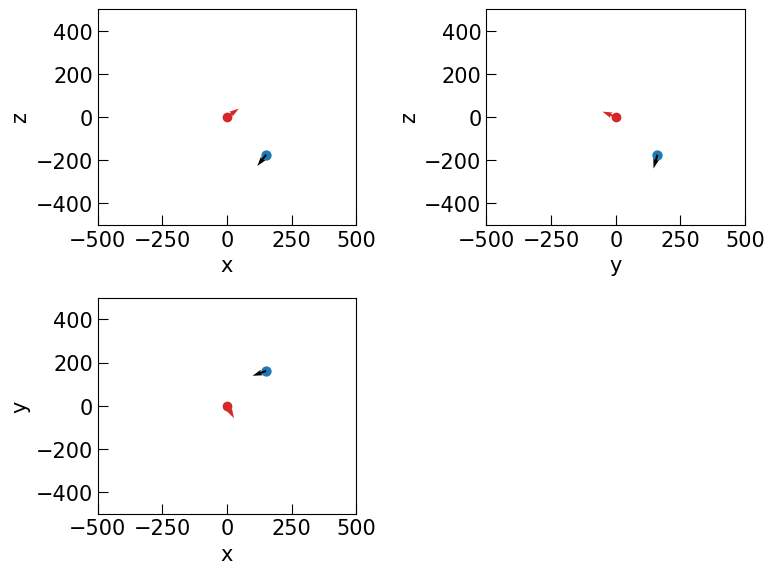

snap_no: 49   Lambda 2.16983595916
[ 3.63489151]


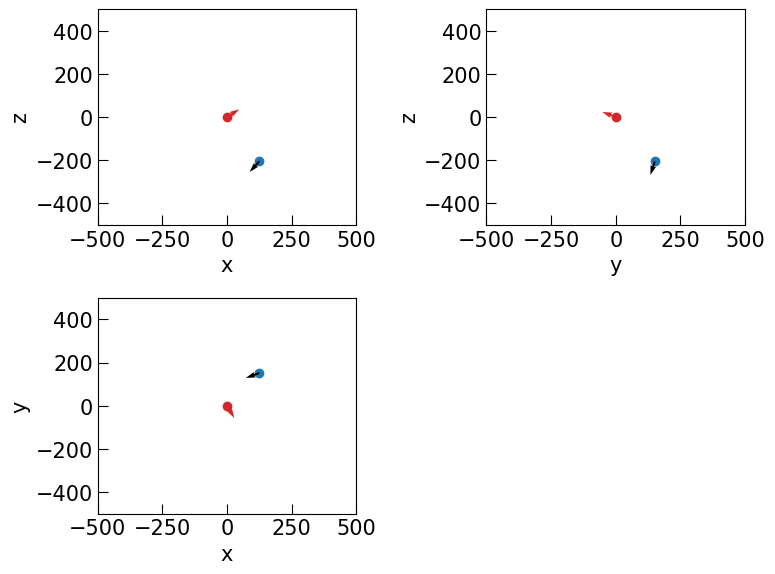

snap_no: 48   Lambda 2.06840967937
[ 30.47571945   4.2166996 ]


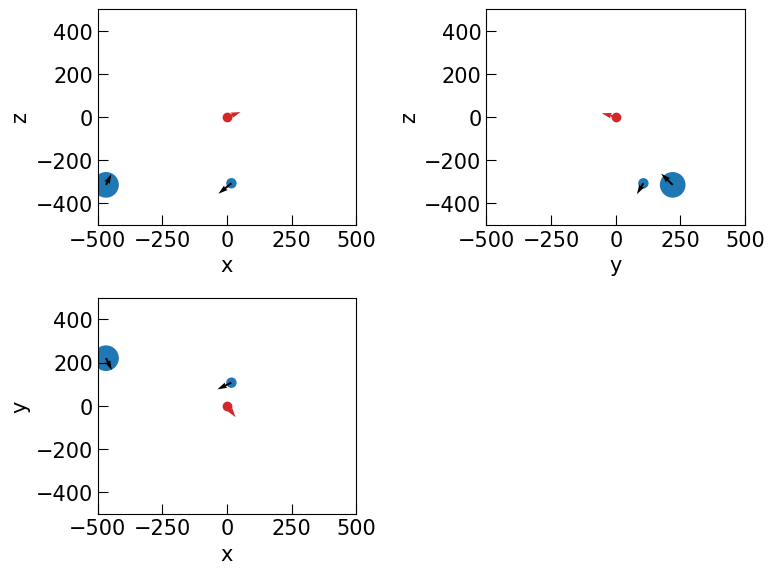

snap_no: 47   Lambda 1.9129683963
[ 24.44220161   4.60436249   2.26397872]


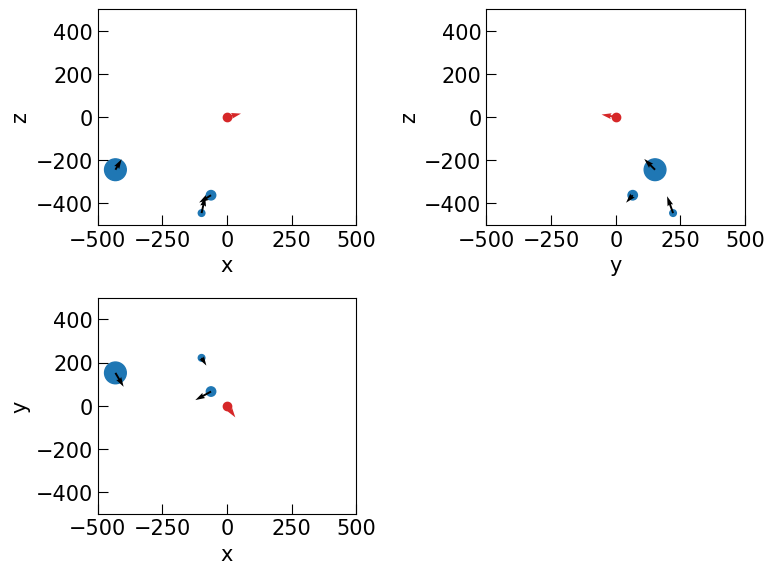

snap_no: 46   Lambda 1.77397623692
[ 20.1184082    7.67686033   4.2943573    2.15939093]


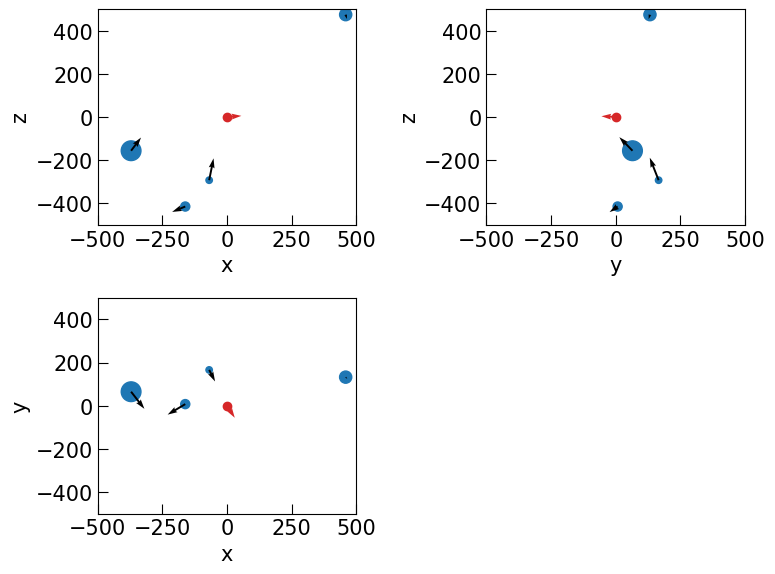

snap_no: 45   Lambda 1.68729502463
[ 16.46285057   7.6718502    4.25615454]


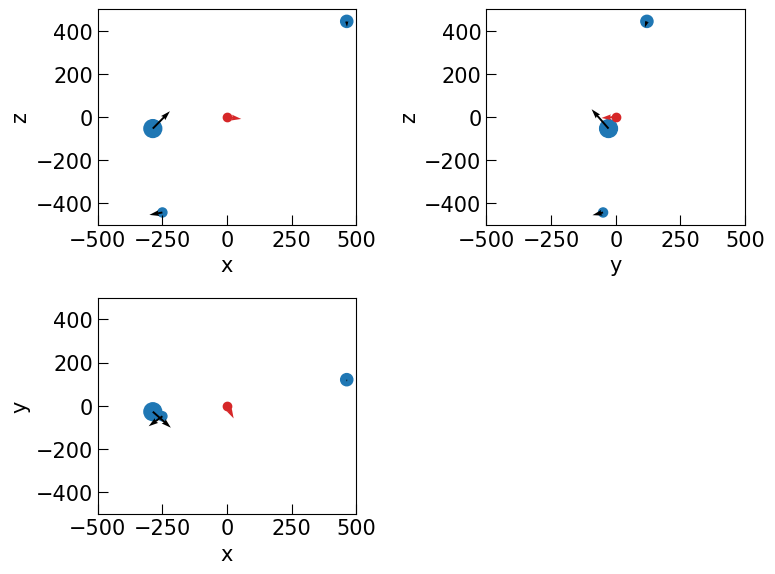

snap_no: 44   Lambda 1.58167770732
[ 10.71240711   7.7758112    4.28558969]


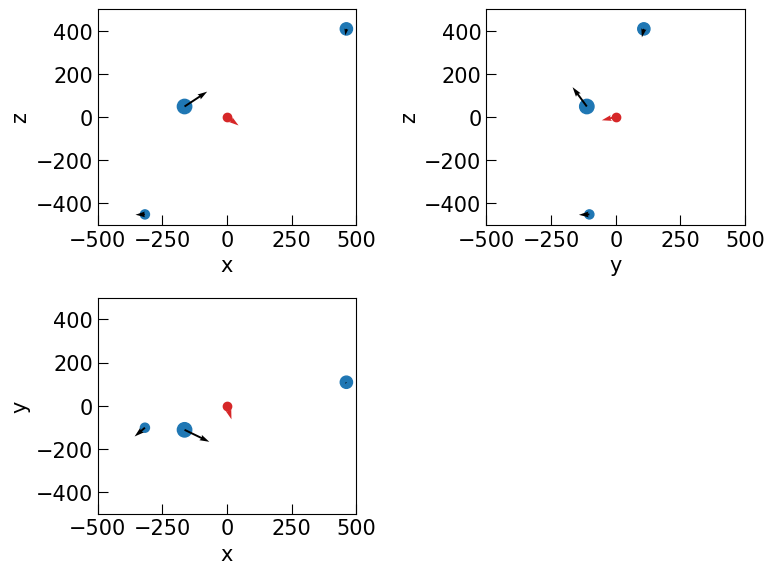

snap_no: 43   Lambda 1.52880370892
[ 7.61423254  7.41946173  4.58995819]


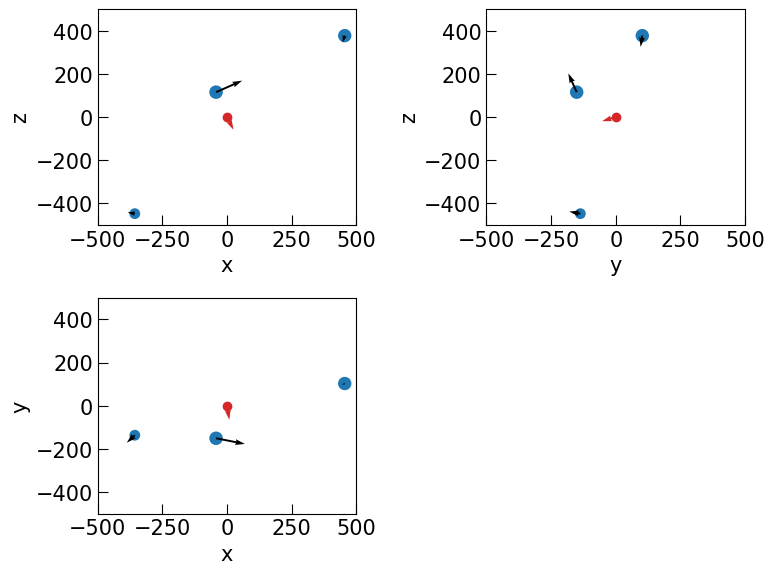

snap_no: 42   Lambda 1.42604096157
[ 23.38693047   9.41790009   7.14515448   4.53547239]


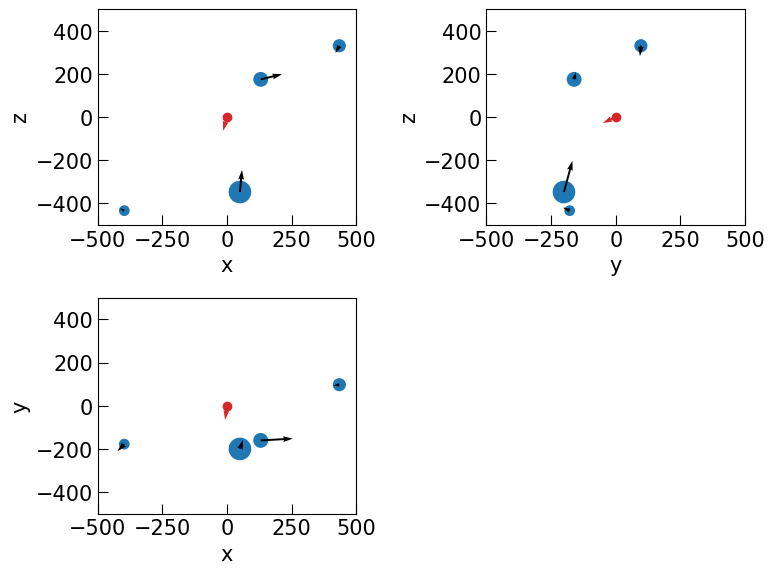

snap_no: 41   Lambda 1.42407265714
[ 13.04966068  13.14109612   6.71866179   4.50728989]


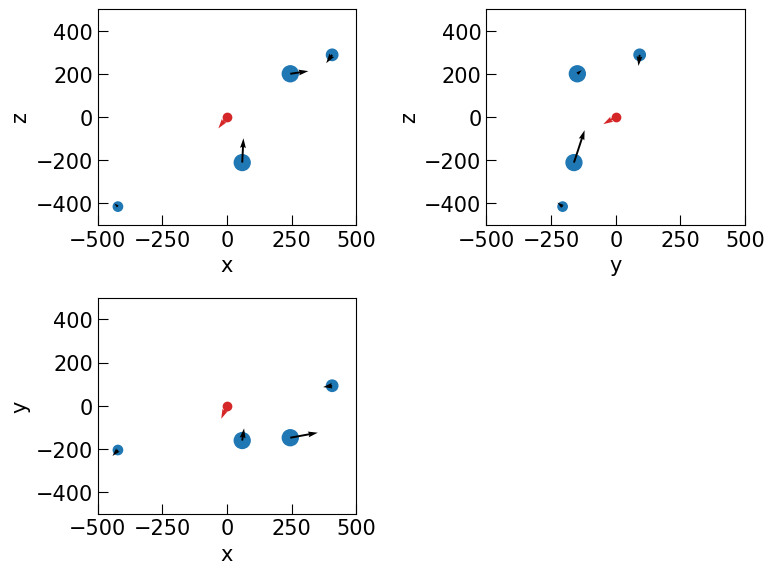

snap_no: 40   Lambda 1.27721431097
[ 14.82451916   4.77721405   6.14436913   4.22671986   2.78190684]


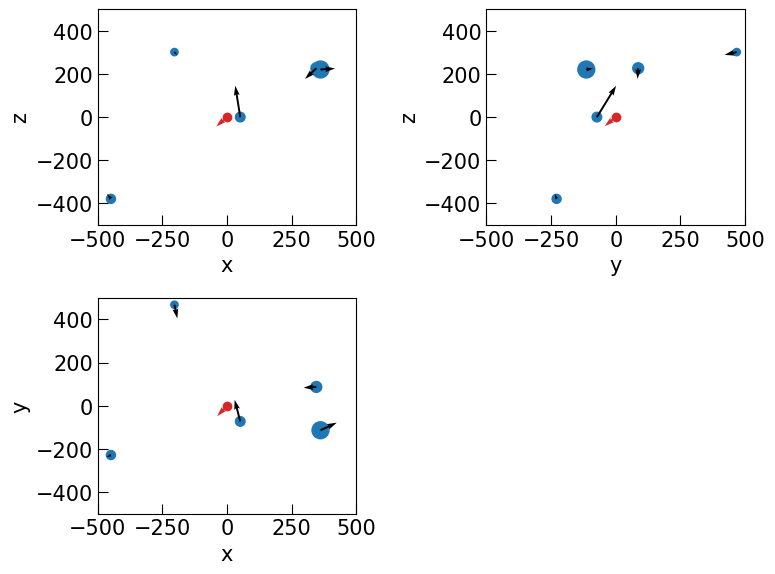

snap_no: 39   Lambda 1.30857616534
[ 14.53142262   4.72022343   5.67215872   4.22797203   2.57022619]


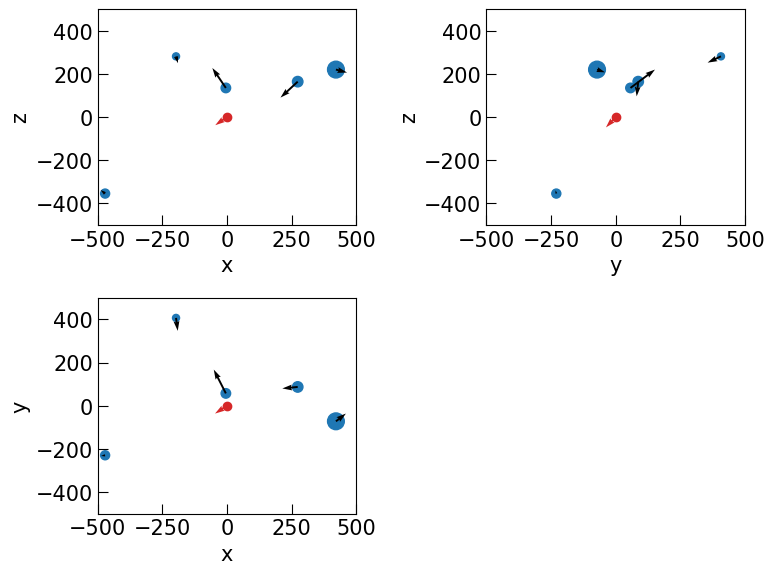

snap_no: 38   Lambda 1.18631081278
[ 11.20465851  13.84627914   4.1684761    4.27181149]


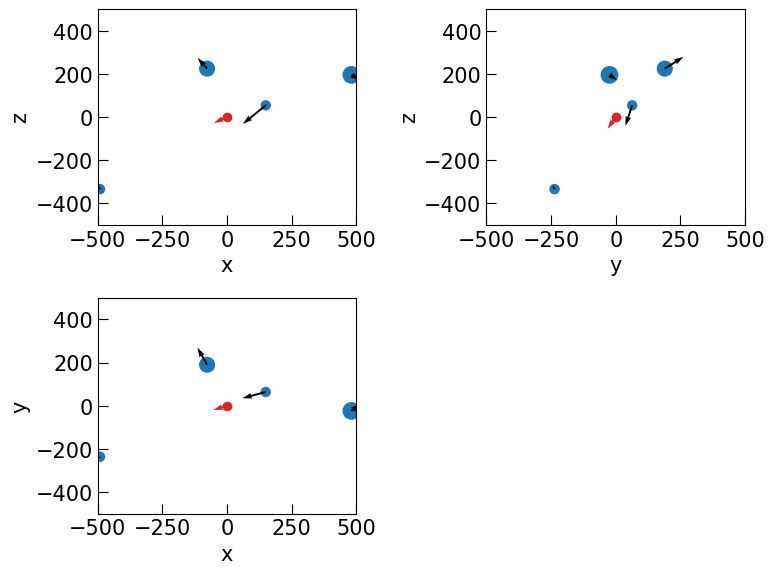

snap_no: 37   Lambda 1.22620797862
[ 12.0895834    4.19728518]


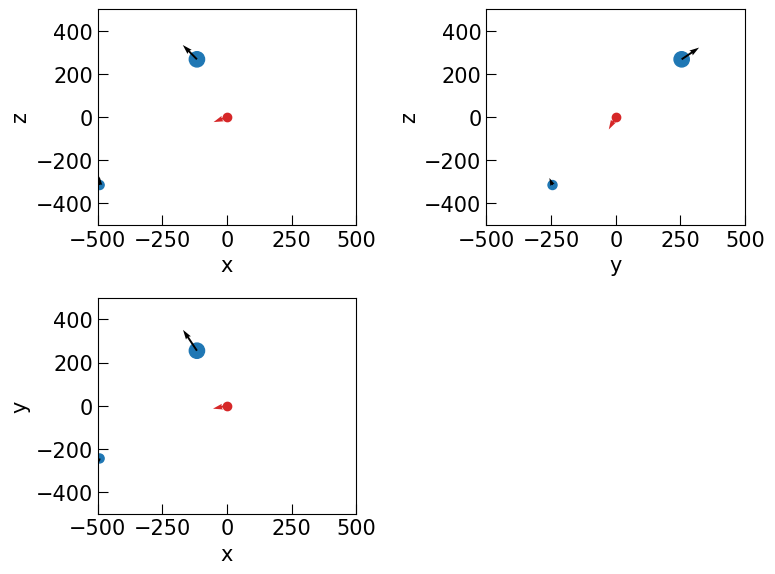

snap_no: 36   Lambda 1.14438876024
[ 9.8237257   4.06764603  2.66228867  2.93158603]


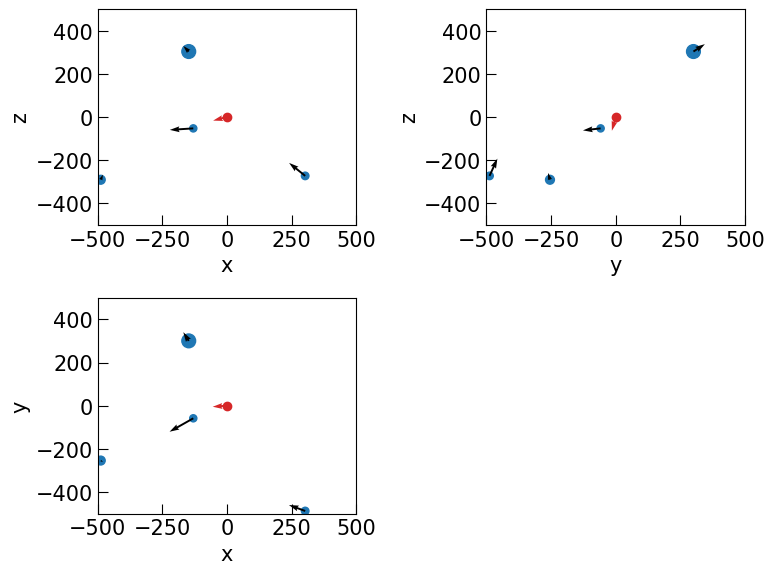

snap_no: 35   Lambda 1.08491731923
[ 10.80259132   3.99186707   3.1626811    2.8576858 ]


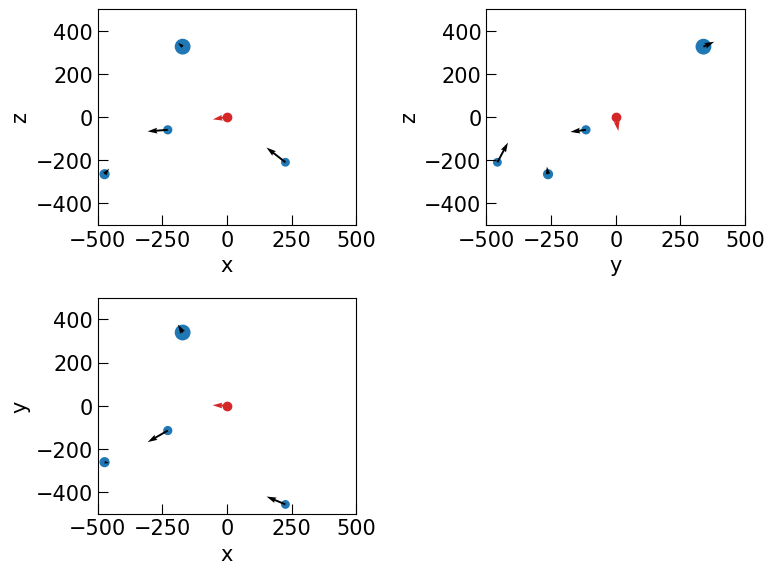

snap_no: 34   Lambda 1.06407925435
[ 11.46268272   3.75263047   3.8735013    3.00861764   2.32096958]


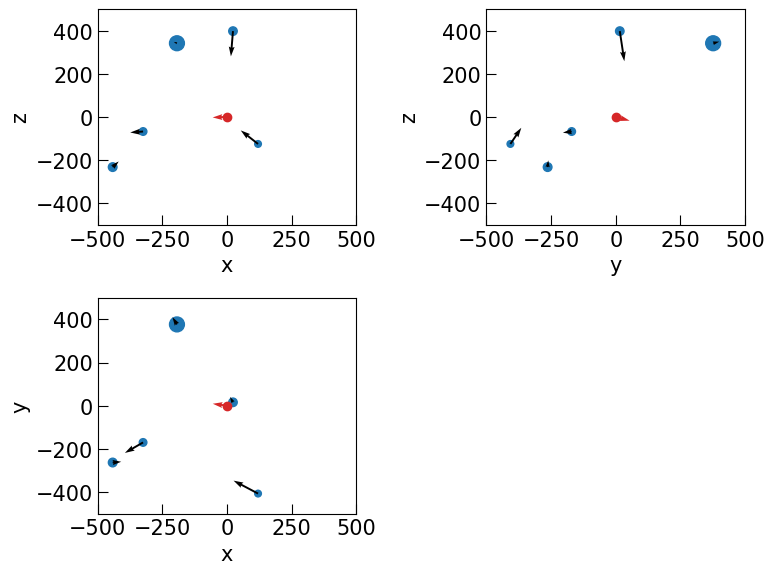

snap_no: 33   Lambda 1.03747837988
[ 12.69080544   3.32926989   3.62737584   2.92093945   2.26710987]


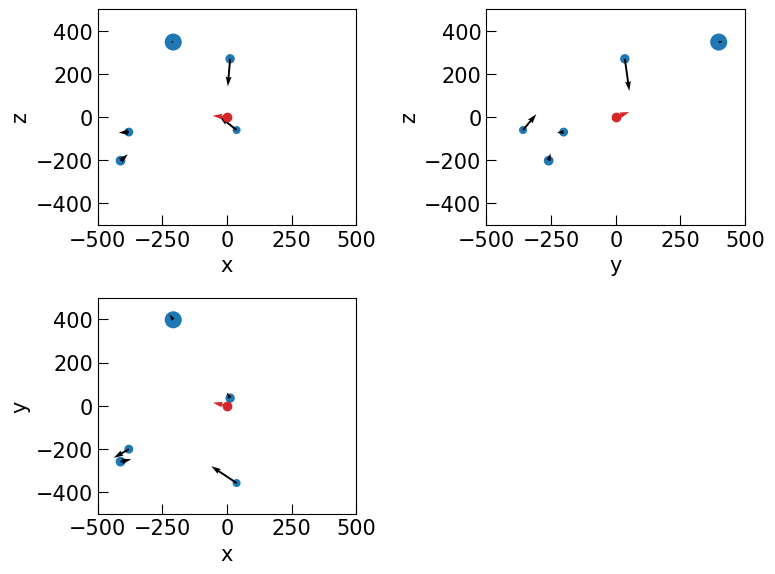

snap_no: 32   Lambda 0.969905473734
[ 13.12481308   3.6900034    2.54517531]


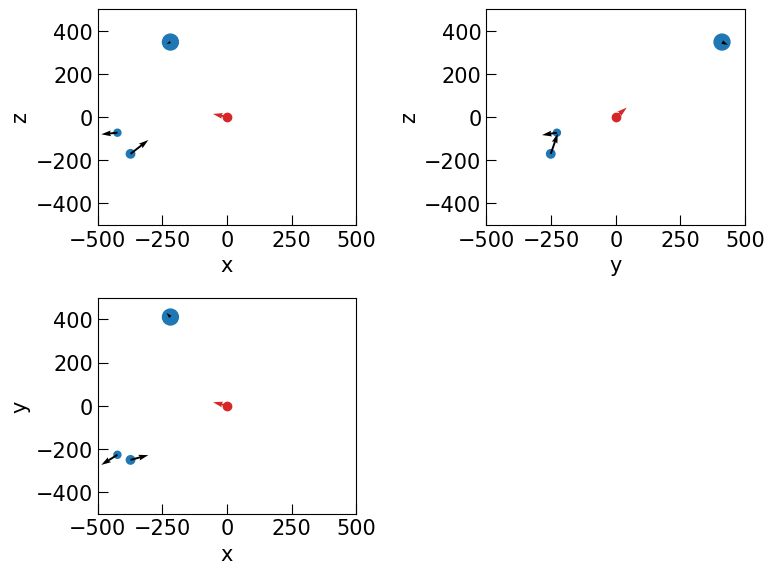

snap_no: 31   Lambda 0.983011078421
[ 12.41461945   3.43197846   2.45687079   2.20260382]


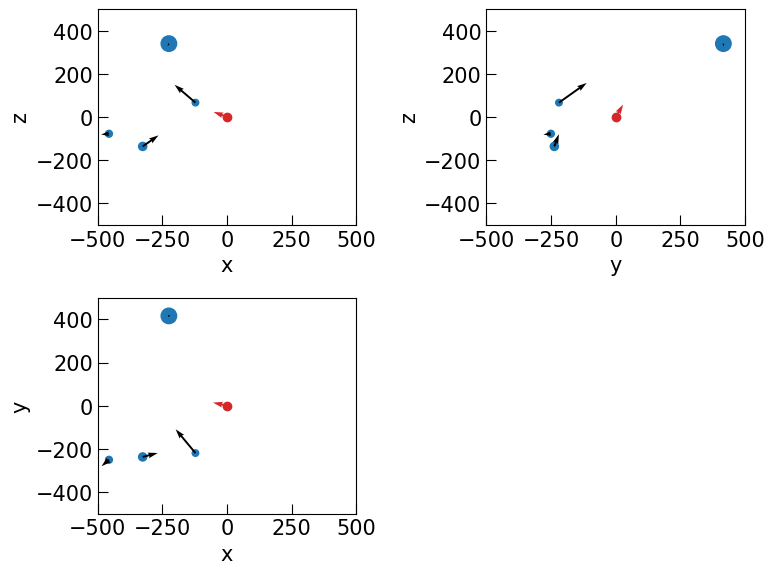

In [471]:
galaxy_number = 6
z_back_start = 0 # counts snapshots from z=1 forward in time
z_back_end = 20
size = 500

for i in  np.arange(25-z_back_start,25-z_back_end,-1):
    nearby_gal = find_gal_in_rad(positions[i]/hubble, masses[i]/hubble, velocities[i], subhalo_numbers[galaxy_number][i+25], size, 2)
    gal_ang_mom = allgalData[i+25][np.argwhere(allgalData[i+25][:,1]==subhalo_numbers[galaxy_number][i+25])[0][0],11:14]
    gal_vel = allgalData[i+25][np.argwhere(allgalData[i+25][:,1]==subhalo_numbers[galaxy_number][i+25])[0][0],8:11]
    gal_lambda = allgalData[i+25][np.argwhere(allgalData[i+25][:,1]==subhalo_numbers[galaxy_number][i+25])[0][0],16]
    nearby_pos = nearby_gal[0]
    nearby_mass = nearby_gal[1]
    nearby_vel = nearby_gal[2]-gal_vel
    #color_map = mass_color_map(nearby_mass,10)
    
    print('snap_no:',i+25,' ','Lambda',gal_lambda)
    
    fig = plt.figure(figsize=(8, 6)); gs=gridspec.GridSpec(2,2)
    
    ax1 = plt.subplot(gs[1,0]); ax2 = plt.subplot(gs[0,0]); ax3 = plt.subplot(gs[0,1]);
    ax1.scatter(nearby_pos[:,0], nearby_pos[:,1], s=nearby_mass*10)#c= vir__cmap(color_map))
    ax1.quiver(nearby_pos[:,0], nearby_pos[:,1], nearby_vel[:,0], nearby_vel[:,1])
    ax1.set_xlabel('x'),ax1.set_ylabel('y')

    ax1.scatter(0,0 ,c='C3'); ax1.set_xlim([-size,size]); ax1.set_ylim([-size,size])
    ax1.quiver(0,0,gal_ang_mom[0],gal_ang_mom[1], facecolor='C3')
    
    ax2.scatter(nearby_pos[:,0], nearby_pos[:,2], s=nearby_mass*10)#c= vir__cmap(color_map))
    ax2.quiver(nearby_pos[:,0], nearby_pos[:,2], nearby_vel[:,0], nearby_vel[:,2])

    ax2.scatter(0,0 ,c='C3');  ax2.set_xlim([-size,size]); ax2.set_ylim([-size,size])
    ax2.quiver(0,0,gal_ang_mom[0],gal_ang_mom[2], facecolor='C3')
    ax2.set_xlabel('x'),ax2.set_ylabel('z')
    
    ax3.scatter(nearby_pos[:,1], nearby_pos[:,2], s=nearby_mass*10)#c= vir__cmap(color_map))
    ax3.quiver(nearby_pos[:,1], nearby_pos[:,2], nearby_vel[:,1], nearby_vel[:,2])
    ax3.scatter(0,0 ,c='C3');  ax3.set_xlim([-size,size]); ax3.set_ylim([-size,size])
    ax3.quiver(0,0,gal_ang_mom[1],gal_ang_mom[2], facecolor='C3')
    ax3.set_xlabel('y'),ax3.set_ylabel('z')
    
    print(nearby_mass)
    plt.tight_layout()
    plt.show()

In [420]:
subhalo_numbers.shape

(10, 51)